In [26]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
layers = keras.layers
import matplotlib.pyplot as plt
F = keras.activations
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions
import pickle
import etas_pkl
import importlib

In [1]:
DEBUG = False
def debug(msg):
    if DEBUG:
        print(msg)


class Distribution:
    def prob(self, x):
        raise NotImplementedError


    def log_prob(self, x):
        raise NotImplementedError


    def survival(self, x):
        raise NotImplementedError


    def log_survival(self, x):
        raise NotImplementedError


    def sample(self, shape):
        raise NotImplementedError


class Gamma(Distribution):
    name = "gamma"
    n_params = 2


    def __init__(self, alpha, beta):
        self.eps = 1e-08
        self.alpha = tf.clip_by_value(alpha, self.eps, tf.reduce_max(alpha))
        self.beta = tf.clip_by_value(beta, self.eps, tf.reduce_max(beta))


    def prob(self, x):
        return tf.math.exp(self.log_prob(x))


    def log_prob(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        return (self.alpha - 1) * tf.math.log(x) \
            + self.alpha * tf.math.log(self.beta) \
            - self.beta * x \
            - tf.math.lgamma(self.alpha)


    def survival(self, x):
        return tf.math.exp(self.log_survival(x))


    def log_survival(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        y = 1 - tf.math.igamma(self.alpha, self.beta * x) \
            / tf.math.exp(tf.math.lgamma(self.alpha))
        y = tf.clip_by_value(y, self.eps, tf.reduce_max(y))
        return tf.math.log(y)


class Weibull(Distribution):
    name = "weibull"
    n_params = 2


    def __init__(self, b, k):
        self.eps = 1e-08
        self.b = tf.clip_by_value(b, self.eps, tf.reduce_max(b))
        self.k = tf.clip_by_value(k, self.eps, tf.reduce_max(k))


    def prob(self, x):
        debug(f"Weibull.prob(x): x.shape = {x.shape}")
        return tf.math.exp(self.log_prob(x))


    def log_prob(self, x):
        debug(f"Weibull.log_prob(x): x.shape = {x.shape}")
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        return tf.math.log(self.b) + tf.math.log(self.k) \
            + (self.k - 1) * tf.math.log(x) \
            - self.b * tf.math.pow(x, self.k)


    def survival(self, x):
        return tf.math.exp(self.log_survival(x))


    def log_survival(self, x):
        x = tf.clip_by_value(x, self.eps, tf.reduce_max(x))
        return -self.b * tf.math.pow(x, self.k)


class Mixture(Distribution):
    def __init__(self, weights, dist):
        if not isinstance(dist, Distribution):
            raise ValueError("Distribution is not supported")
        self.weights = tf.Variable(weights, dtype=tf.float32)
        self.dist = dist


    def prob(self, x):
        debug(f"Weibull.prob(x): x.shape = {x.shape}")
        x = tf.expand_dims(x, axis=-1)
        return tf.squeeze(tf.reduce_sum(self.weights * self.dist.prob(x), axis=-1))


    def log_prob(self, x):
        debug(f"Mixture.log_prob(x): x.shape = {x.shape}")
        y = self.prob(x)
        y = tf.clip_by_value(y, self.dist.eps, tf.reduce_max(y))
        return tf.math.log(y)


    def survival(self, x):
        x = tf.expand_dims(x, axis=-1)
        return tf.squeeze(tf.reduce_sum(self.weights * self.dist.survival(x), axis=-1))


    def log_survival(self, x):
        y = self.survival(x)
        y = tf.clip_by_value(y, self.dist.eps, tf.reduce_max(y))
        return tf.math.log(y)


class Model:
    def __init__(self, context_size=32, dist=Weibull, num_cmpts=1, lr=5e-3):
        if not issubclass(dist, Distribution):
            raise ValueError("Distribution is not supported")
        self.context_size = context_size
        self.encoder = keras.layers.GRU(context_size, return_sequences=True)
        # self.decoder = keras.layers.Dense((dist.n_params + 1) * num_cmpts)
        self.decoder = keras.layers.Dense(num_cmpts * (dist.n_params + 1))
        self.optimizer = keras.optimizers.Adam(learning_rate=lr)
        self.dist = dist
        self.num_cmpts = num_cmpts
        self.params = []
        if num_cmpts > 1:
            print(f"Model will train with a mixture of {num_cmpts} \
{dist.name.title()} distributions")
        else:
            print(f"Model will train with a {dist.name.title()} distribution")


    def get_context(self, inter_times):
        tau = tf.expand_dims(inter_times, axis=-1)
        log_tau = tf.math.log(tf.clip_by_value(tau, 1e-8, tf.reduce_max(tau)))
        input = tf.concat([tau, log_tau], axis=-1)
        output = self.encoder(input)
        context = tf.pad(output[:, :-1, :], [[0, 0], [1, 0], [0, 0]])
        return context


    def get_inter_times_distribution(self, context):
        params = self.decoder(context)
        # debug(f"params.shape = {params.shape}")
        weights = F.softmax(params[..., :self.num_cmpts])
        self.params.append({"weights": weights})
        # debug(f"weights.shape = {weights.shape}")
        params_list = []
        for i in range(1, self.dist.n_params + 1):
            params_list.append(F.softplus(params[..., i * self.num_cmpts:(i+1) * self.num_cmpts]))
            self.params[-1][f"param_{i}"] = params_list[-1]
        
        # for param in params_list:
        #     debug(f"param.shape = {param.shape}")
        debug(f"{params_list[0][-1, -1, -1]:.2f}, {params_list[1][-1, -1, -1]:.2f}")
        return Mixture(weights, self.dist(*params_list))


    def nll_loss(self, inter_times, seq_lengths):
        context = self.get_context(inter_times)
        inter_times_dist = self.get_inter_times_distribution(context)

        # inter_times = tf.expand_dims(inter_times, axis=-1)
        log_pdf = inter_times_dist.log_prob(inter_times)
        log_surv = inter_times_dist.log_survival(inter_times)

        # debug(f"log_pdf.shape =, {log_pdf.shape}")
        # debug(f"log_surv.shape = {log_surv.shape}")

        # debug(f"log_pdf {np.sum(np.isnan(log_pdf))}")
        # debug(f"log_surv {np.sum(np.isnan(log_surv))}")

        # construit un masque pour ne sélectionner que les éléments
        # nécessaires dans chaque liste
        mask = np.cumsum(np.ones_like(log_pdf), axis=-1) \
            <= np.expand_dims(seq_lengths, axis=-1)
        log_like = tf.reduce_sum(log_pdf * mask, axis=-1)

        # print("log_pdf * mask ", np.sum(np.isnan(log_pdf * mask)))
        
        # idx est une liste de la forme [(a1, b1), (a2, b2), ...]
        # gather_nd sélectionne les éléments correspondant à ces indices
        # (ligne et colonne)
        idx = list(zip(range(len(seq_lengths)), seq_lengths))
        log_surv_last = tf.gather_nd(log_surv, idx)
        # print("log_surv_last ", np.sum(np.isnan(log_surv_last)))
        log_like += log_surv_last

        return -log_like
    

    @property
    def weights(self):
        return self.encoder.trainable_weights + self.decoder.trainable_weights


    def fit(self, epochs, inter_times, seq_lengths, t_end):
        for epoch in range(epochs + 1):
            with tf.GradientTape() as tape:
                loss = tf.reduce_mean(self.nll_loss(inter_times,
                                                    seq_lengths)) / t_end
            grads = tape.gradient(loss, self.weights)
            # debug(f"grads {np.sum([np.sum(np.isnan(grad)) for grad in grads])}")
            self.optimizer.apply_gradients(zip(grads, self.weights))

            if epoch % 10 == 0:
                print(f"Loss at epoch {epoch}: {loss:.2f}")

Model will train with a Weibull distribution
Loss at epoch 0: 1.19
Loss at epoch 10: 0.84
Loss at epoch 20: 0.80
Loss at epoch 30: 0.80
Loss at epoch 40: 0.79
Loss at epoch 50: 0.78
Loss at epoch 60: 0.78
Loss at epoch 70: 0.77
Loss at epoch 80: 0.76


In [ ]:
file = open("dataset.pkl", "rb")
data = pickle.load(file)
t_end = data["t_end"]
arrival_times = data["arrival_times"]

seq_lengths = [len(times) for times in arrival_times]
inter_times_list = [np.diff(times, prepend=0, append=t_end)
                    for times in arrival_times]

inter_times = np.asarray([np.pad(inter_times, (0, np.max(seq_lengths) - size))
        for size, inter_times in zip(seq_lengths, inter_times_list)])

inter_times = tf.Variable(inter_times, dtype=tf.float32)

model = Model(context_size=32, dist=Weibull, num_cmpts=1)
model.fit(80, inter_times, seq_lengths, t_end)

### Vérification avec des lois classiques (mélanges à une composante)

Model will train with a Weibull distribution
Loss at epoch 0: 0.76
Loss at epoch 10: 0.57
Loss at epoch 20: 0.57
Loss at epoch 30: 0.57
Loss at epoch 40: 0.57
Loss at epoch 50: 0.57
Loss at epoch 60: 0.56
Loss at epoch 70: 0.56
Loss at epoch 80: 0.56
Loss at epoch 90: 0.56
Loss at epoch 100: 0.56
Loss at epoch 110: 0.56
Loss at epoch 120: 0.56
Loss at epoch 130: 0.56
Loss at epoch 140: 0.56
Loss at epoch 150: 0.56


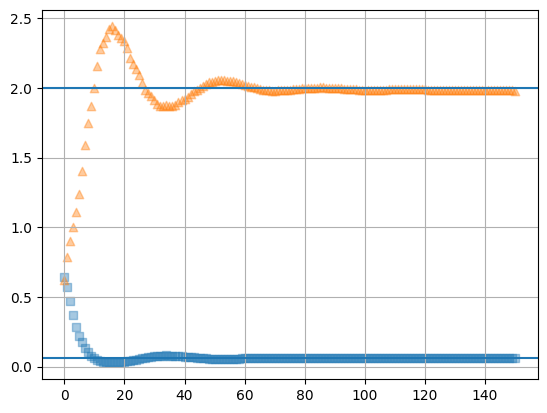

In [2]:
k = 2
lambd = 4
b1 = lambd ** (-k)
k1 = k
inter_times = tfd.Weibull(k, lambd).sample([100, 100])
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32, dist=Weibull, num_cmpts=1)
model.fit(150, inter_times, seq_lengths, t_end)

epochs = range(len(model.params))
b_list = [np.mean(model.params[i]["param_1"][:, -1, 0]) for i in epochs]
k_list = [np.mean(model.params[i]["param_2"][:, -1, 0]) for i in epochs]
plt.scatter(epochs, b_list, marker="s", alpha=0.4)
plt.scatter(epochs, k_list, marker="^", alpha=0.4)
plt.axhline(b1)
plt.axhline(k1)
plt.grid()
plt.show()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Model will train with a Gamma distribution
Loss at epoch 0: 1.00
Loss at epoch 10: 0.64
Loss at epoch 20: 0.64
Loss at epoch 30: 0.62
Loss at epoch 40: 0.62
Loss at epoch 50: 0.62
Loss at epoch 60: 0.61
Loss at epoch 70: 0.61
Loss at epoch 80: 0.61
Loss at epoch 90: 0.61
Loss at epoch 100: 0.61
Loss at epoch 110: 0.61
Loss at epoch 120: 0.61
Loss at epoch 130: 0.61
Loss at epoch 140: 0.61
Loss at epoch 150: 0.61


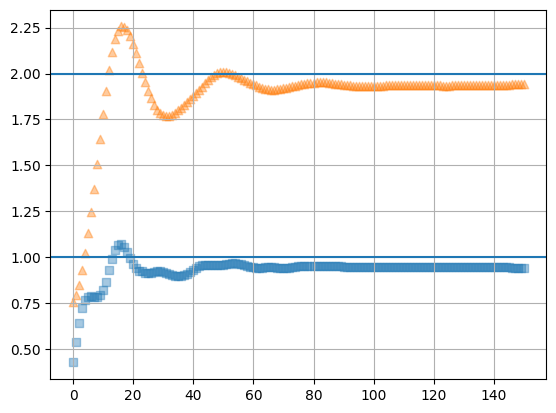

In [3]:
alpha = 1
beta = 2
inter_times = tfd.Gamma(alpha, beta).sample([100, 100])
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32, dist=Gamma, num_cmpts=1)
model.fit(150, inter_times, seq_lengths, t_end)

epochs = range(len(model.params))
alpha_list = [np.mean(model.params[i]["param_1"][:, -1, 0]) for i in epochs]
beta_list = [np.mean(model.params[i]["param_2"][:, -1, 0]) for i in epochs]
plt.scatter(epochs, alpha_list, marker="s", alpha=0.4)
plt.scatter(epochs, beta_list, marker="^", alpha=0.4)
plt.axhline(alpha)
plt.axhline(beta)
plt.grid()
plt.show()

Model will train with a Gamma distribution
Loss at epoch 0: 0.80
Loss at epoch 10: 0.39
Loss at epoch 20: 0.37
Loss at epoch 30: 0.35
Loss at epoch 40: 0.34
Loss at epoch 50: 0.34
Loss at epoch 60: 0.34
Loss at epoch 70: 0.34
Loss at epoch 80: 0.34
Loss at epoch 90: 0.34
Loss at epoch 100: 0.34
Loss at epoch 110: 0.34
Loss at epoch 120: 0.34
Loss at epoch 130: 0.34
Loss at epoch 140: 0.34
Loss at epoch 150: 0.34


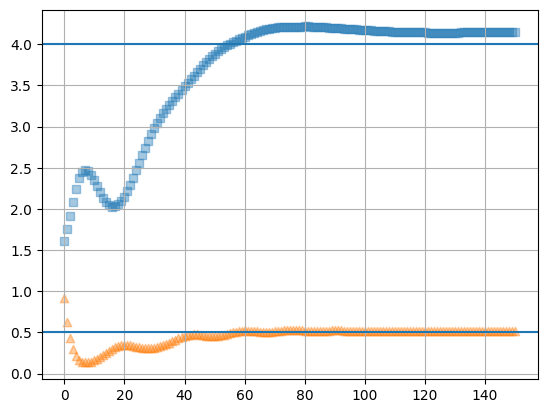

In [4]:
alpha = 4
beta = 0.5
inter_times = tfd.Gamma(alpha, beta).sample([100, 100])
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32, dist=Gamma, num_cmpts=1)
model.fit(150, inter_times, seq_lengths, t_end)

epochs = range(len(model.params))
alpha_list = [np.mean(model.params[i]["param_1"][:, -1, 0]) for i in epochs]
beta_list = [np.mean(model.params[i]["param_2"][:, -1, 0]) for i in epochs]
plt.scatter(epochs, alpha_list, marker="s", alpha=0.4)
plt.scatter(epochs, beta_list, marker="^", alpha=0.4)
plt.axhline(alpha)
plt.axhline(beta)
plt.grid()
plt.show()

### Avec une loi de mélange

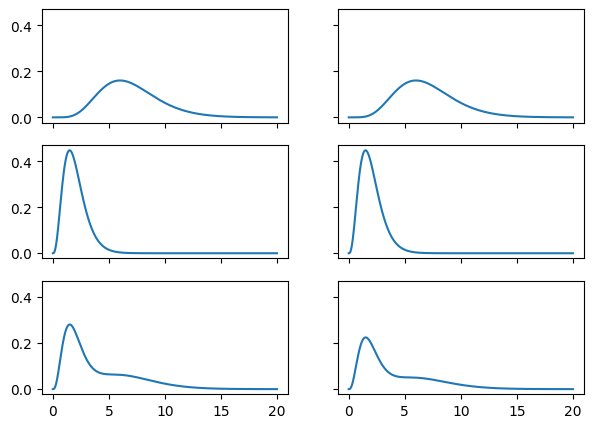

In [5]:
g1 = tfd.Gamma(7., 1.)
g2 = tfd.Gamma(4., 2.)
mix1 = tfd.MixtureSameFamily(
    tfd.Categorical(probs=[0.3, 0.5]),
    tfd.Gamma([7., 4.], [1., 2.])
)

g1 = Gamma(7., 1.)
g2 = Gamma(4., 2.)
mix2 = Mixture([0.3, 0.5], Gamma([7., 4.], [1., 2.]))

fig, axes = plt.subplots(3, 2, figsize=(7, 5),
                         sharex=True, sharey=True)

x = np.linspace(0, 20, 1000).astype(np.float32)
axes[0, 0].plot(x, g1.prob(x))
axes[1, 0].plot(x, g2.prob(x))
axes[2, 0].plot(x, mix1.prob(x))

axes[0, 1].plot(x, g1.prob(x))
axes[1, 1].plot(x, g2.prob(x))
axes[2, 1].plot(x, mix2.prob(x))

plt.show()

Model will train with a mixture of 3 Gamma distributions
Loss at epoch 0: 1.00
Loss at epoch 10: 0.89
Loss at epoch 20: 0.88
Loss at epoch 30: 0.86
Loss at epoch 40: 0.86
Loss at epoch 50: 0.86
Loss at epoch 60: 0.86
Loss at epoch 70: 0.86
Loss at epoch 80: 0.86
Loss at epoch 90: 0.86
Loss at epoch 100: 0.86


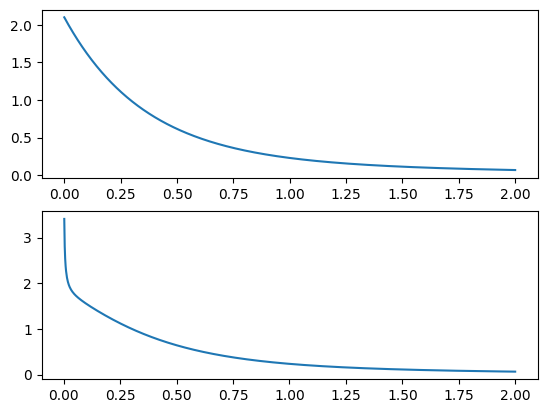

In [6]:
mix = tfd.MixtureSameFamily(
    tfd.Categorical(probs=[0.3, 0.2, 0.5]),
    tfd.Gamma([1., 2., 1.], [2., 1., 3.])
)

inter_times = mix.sample([100, 100])
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32, dist=Gamma, num_cmpts=3)
model.fit(100, inter_times, seq_lengths, t_end)

epochs = range(len(model.params))
weight_list = [model.params[i]["weights"][:, -1] for i in epochs]
alpha_list = [model.params[i]["param_1"][:, -1] for i in epochs]
beta_list = [model.params[i]["param_2"][:, -1] for i in epochs]

# print(model.params[0]["weights"].shape)

weights = weight_list[-1][-1]
alphas = alpha_list[-1][-1]
betas = beta_list[-1][-1]

# print(weights)
# print(alphas)
# print(betas)

mix_pred = tfd.MixtureSameFamily(
    tfd.Categorical(probs=weights),
    tfd.Gamma(alphas, betas)
)

x = np.linspace(0, 2, 1000)
fig, axes = plt.subplots(2, 1)
axes[0].plot(x, mix.prob(x))
axes[1].plot(x, mix_pred.prob(x))
plt.show()

Model will train with a Gamma distribution
Loss at epoch 0: 0.60
Loss at epoch 10: 0.58
Loss at epoch 20: 0.56
Loss at epoch 30: 0.56
Loss at epoch 40: 0.55
Loss at epoch 50: 0.55


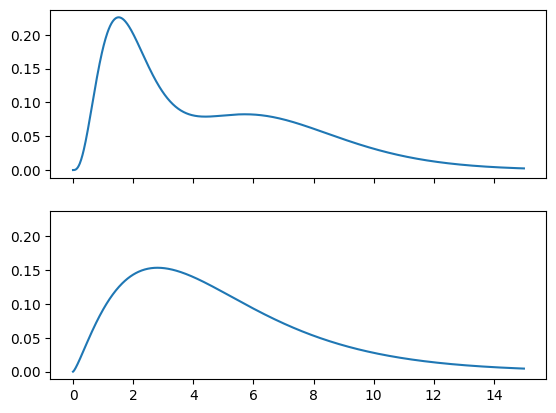

In [7]:
mix = tfd.MixtureSameFamily(
    tfd.Categorical(probs=[0.5, 0.5]),
    tfd.Gamma([7., 4.], [1., 2.])
)

inter_times = mix.sample([100, 100])
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32, dist=Gamma, num_cmpts=1)
model.fit(50, inter_times, seq_lengths, t_end)

epochs = range(len(model.params))
weight_list = [model.params[i]["weights"][:, -1] for i in epochs]
alpha_list = [model.params[i]["param_1"][:, -1] for i in epochs]
beta_list = [model.params[i]["param_2"][:, -1] for i in epochs]

weights = weight_list[-1][-1]
alphas = alpha_list[-1][-1]
betas = beta_list[-1][-1]

# print(weights)
# print(alphas)
# print(betas)

mix_pred = tfd.MixtureSameFamily(
    tfd.Categorical(probs=weights),
    tfd.Gamma(alphas, betas)
)

x = np.linspace(0, 15, 1000)
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].plot(x, mix.prob(x))
axes[1].plot(x, mix_pred.prob(x))
plt.show()

Model will train with a mixture of 5 Gamma distributions
Loss at epoch 0: 0.82
Loss at epoch 10: 0.58
Loss at epoch 20: 0.56
Loss at epoch 30: 0.55
Loss at epoch 40: 0.54
Loss at epoch 50: 0.54


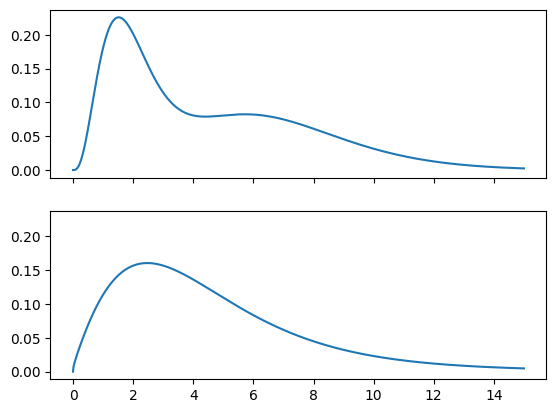

In [8]:
mix = tfd.MixtureSameFamily(
    tfd.Categorical(probs=[0.5, 0.5]),
    tfd.Gamma([7., 4.], [1., 2.])
)

inter_times = mix.sample([100, 100])
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32, dist=Gamma, num_cmpts=5)
model.fit(50, inter_times, seq_lengths, t_end)

epochs = range(len(model.params))
weight_list = [model.params[i]["weights"][:, -1] for i in epochs]
alpha_list = [model.params[i]["param_1"][:, -1] for i in epochs]
beta_list = [model.params[i]["param_2"][:, -1] for i in epochs]

weights = weight_list[-1][-1]
alphas = alpha_list[-1][-1]
betas = beta_list[-1][-1]

# print(weights)
# print(alphas)
# print(betas)

mix_pred = tfd.MixtureSameFamily(
    tfd.Categorical(probs=weights),
    tfd.Gamma(alphas, betas)
)

x = np.linspace(0, 15, 1000)
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].plot(x, mix.prob(x))
axes[1].plot(x, mix_pred.prob(x))
plt.show()

Model will train with a mixture of 3 Gamma distributions
Loss at epoch 0: 0.83
Loss at epoch 10: 0.58
Loss at epoch 20: 0.56
Loss at epoch 30: 0.55
Loss at epoch 40: 0.55
Loss at epoch 50: 0.54
Loss at epoch 60: 0.54
Loss at epoch 70: 0.54
Loss at epoch 80: 0.54
Loss at epoch 90: 0.54
Loss at epoch 100: 0.54
Loss at epoch 110: 0.54
Loss at epoch 120: 0.54
Loss at epoch 130: 0.54
Loss at epoch 140: 0.54
Loss at epoch 150: 0.54
Loss at epoch 160: 0.54
Loss at epoch 170: 0.54
Loss at epoch 180: 0.54
Loss at epoch 190: 0.54
Loss at epoch 200: 0.54


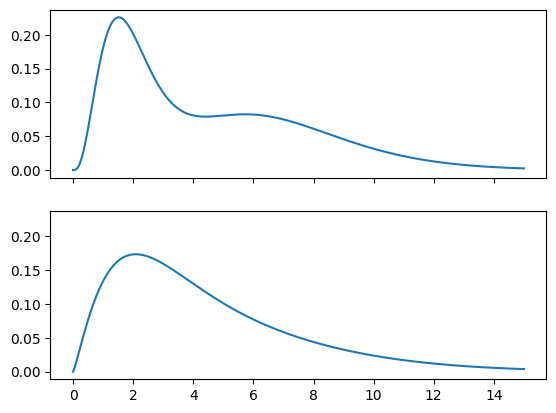

In [12]:
mix = tfd.MixtureSameFamily(
    tfd.Categorical(probs=[0.5, 0.5]),
    tfd.Gamma([7., 4.], [1., 2.])
)

inter_times = mix.sample([100, 100])
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32, dist=Gamma, num_cmpts=3)
model.fit(200, inter_times, seq_lengths, t_end)

epochs = range(len(model.params))
weight_list = [model.params[i]["weights"][:, -1] for i in epochs]
alpha_list = [model.params[i]["param_1"][:, -1] for i in epochs]
beta_list = [model.params[i]["param_2"][:, -1] for i in epochs]

weights = weight_list[-1][-1]
alphas = alpha_list[-1][-1]
betas = beta_list[-1][-1]

# print(weights)
# print(alphas)
# print(betas)

mix_pred = tfd.MixtureSameFamily(
    tfd.Categorical(probs=weights),
    tfd.Gamma(alphas, betas)
)

x = np.linspace(0, 15, 1000)
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].plot(x, mix.prob(x))
axes[1].plot(x, mix_pred.prob(x))
plt.show()

Model will train with a mixture of 10 Gamma distributions
Loss at epoch 0: 0.76
Loss at epoch 10: 0.57
Loss at epoch 20: 0.55
Loss at epoch 30: 0.54
Loss at epoch 40: 0.54
Loss at epoch 50: 0.54
Loss at epoch 60: 0.53
Loss at epoch 70: 0.53
Loss at epoch 80: 0.53
Loss at epoch 90: 0.53
Loss at epoch 100: 0.52
Loss at epoch 110: 0.52
Loss at epoch 120: 0.52
Loss at epoch 130: 0.52
Loss at epoch 140: 0.52
Loss at epoch 150: 0.52
Loss at epoch 160: 0.52
Loss at epoch 170: 0.52
Loss at epoch 180: 0.52
Loss at epoch 190: 0.52
Loss at epoch 200: 0.52


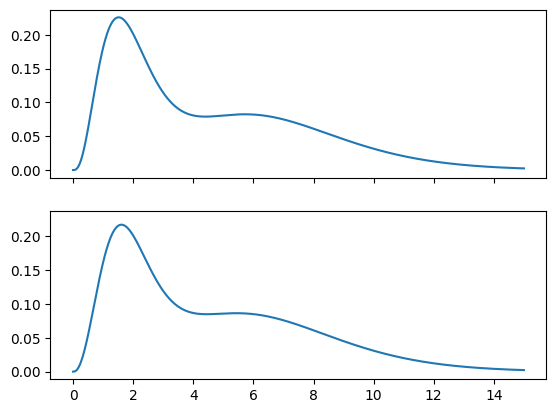

In [13]:
mix = tfd.MixtureSameFamily(
    tfd.Categorical(probs=[0.5, 0.5]),
    tfd.Gamma([7., 4.], [1., 2.])
)

inter_times = mix.sample([100, 100])
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32, dist=Gamma, num_cmpts=10)
model.fit(200, inter_times, seq_lengths, t_end)

epochs = range(len(model.params))
weight_list = [model.params[i]["weights"][:, -1] for i in epochs]
alpha_list = [model.params[i]["param_1"][:, -1] for i in epochs]
beta_list = [model.params[i]["param_2"][:, -1] for i in epochs]

weights = weight_list[-1][-1]
alphas = alpha_list[-1][-1]
betas = beta_list[-1][-1]

# print(weights)
# print(alphas)
# print(betas)

mix_pred = tfd.MixtureSameFamily(
    tfd.Categorical(probs=weights),
    tfd.Gamma(alphas, betas)
)

x = np.linspace(0, 15, 1000)
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].plot(x, mix.prob(x))
axes[1].plot(x, mix_pred.prob(x))
plt.show()

Model will train with a mixture of 3 Weibull distributions
Loss at epoch 0: 0.75
Loss at epoch 10: 0.51
Loss at epoch 20: 0.48
Loss at epoch 30: 0.47
Loss at epoch 40: 0.47
Loss at epoch 50: 0.47
Loss at epoch 60: 0.46
Loss at epoch 70: 0.46
Loss at epoch 80: 0.46
Loss at epoch 90: 0.46
Loss at epoch 100: 0.46


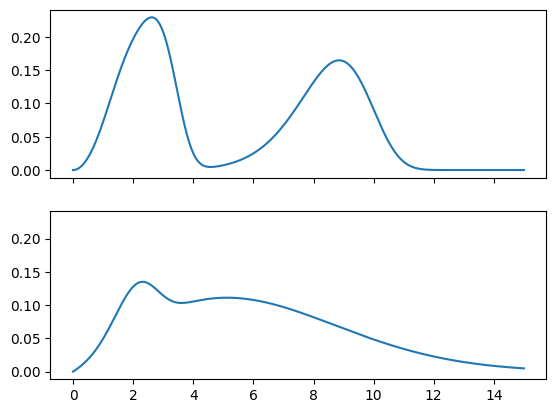

In [11]:
mix = tfd.MixtureSameFamily(
    tfd.Categorical(probs=[0.3, 0.2, 0.5]),
    tfd.Weibull([5, 3., 8.], [3., 2., 9.])
)

inter_times = mix.sample([100, 100])
arrival_times = np.cumsum(inter_times, axis=-1)
eps = 1e-8
t_end = np.min(arrival_times[:, -1]) - eps
seq_lengths = np.sum(arrival_times < t_end, axis=-1)

model = Model(context_size=32, dist=Weibull, num_cmpts=3)
model.fit(100, inter_times, seq_lengths, t_end)

epochs = range(len(model.params))
weight_list = [model.params[i]["weights"][:, -1] for i in epochs]
alpha_list = [model.params[i]["param_1"][:, -1] for i in epochs]
beta_list = [model.params[i]["param_2"][:, -1] for i in epochs]

weights = weight_list[-1][-1]
b = alpha_list[-1][-1]
k = beta_list[-1][-1]

# print(weights)
# print(b)
# print(k)

mix_pred = Mixture(weights, Weibull(b, k))

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
x = np.linspace(0, 15, 1000).astype(np.float32)
axes[0].plot(x, mix.prob(x))
axes[1].plot(x, mix_pred.prob(x))
plt.show()

Model will train with a mixture of 3 Weibull distributions
Loss at epoch 0: 0.70
Loss at epoch 10: 0.52
Loss at epoch 20: 0.48
Loss at epoch 30: 0.47
Loss at epoch 40: 0.46
Loss at epoch 50: 0.45
Loss at epoch 60: 0.44
Loss at epoch 70: 0.44
Loss at epoch 80: 0.44
Loss at epoch 90: 0.43
Loss at epoch 100: 0.43
Loss at epoch 110: 0.42
Loss at epoch 120: 0.41
Loss at epoch 130: 0.41
Loss at epoch 140: 0.40
Loss at epoch 150: 0.40
Loss at epoch 160: 0.40
Loss at epoch 170: 0.40
Loss at epoch 180: 0.40
Loss at epoch 190: 0.39
Loss at epoch 200: 0.39


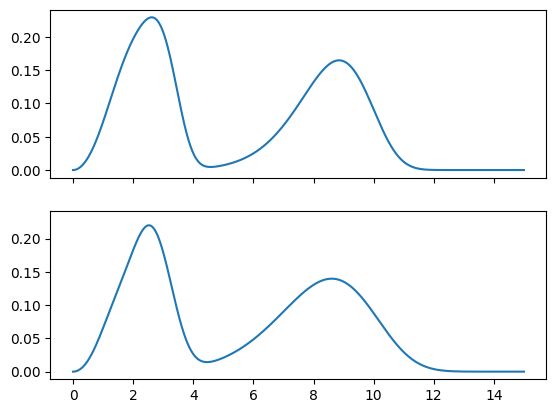

In [10]:
model = Model(context_size=32, dist=Weibull, num_cmpts=3)
model.fit(200, inter_times, seq_lengths, t_end)

epochs = range(len(model.params))
weight_list = [model.params[i]["weights"][:, -1] for i in epochs]
alpha_list = [model.params[i]["param_1"][:, -1] for i in epochs]
beta_list = [model.params[i]["param_2"][:, -1] for i in epochs]

weights = weight_list[-1][-1]
b = alpha_list[-1][-1]
k = beta_list[-1][-1]

# print(weights)
# print(b)
# print(k)

mix_pred = Mixture(weights, Weibull(b, k))

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
x = np.linspace(0, 15, 1000).astype(np.float32)
axes[0].plot(x, mix.prob(x))
axes[1].plot(x, mix_pred.prob(x))
plt.show()

### Données ETAS

In [34]:
importlib.reload(etas_pkl)
data = etas_pkl.gen_dataset("--verbose --print_config --num_seqs 1000",
                              save=True, filename="etas.pkl")

Program configuration:
  --tmax		100
  --mu			1
  --alpha		2
  --bar_n		0.9
  --p			1.1
  --c			1e-09
  --beta		2.30259

  --generate_seqs	true
  --num_seqs		1000
  --max_len		300

  --filename		data.csv
  --dirname		data_temp_seqs

  --verbose		true
Generating sequences...
[========================================] 100% 


In [35]:
len(data)

1000

In [36]:
type(data[0])

pandas.core.frame.DataFrame

In [37]:
data[0].head()

,TIME,MAG,PARENT
ID,,,
1,0.655288,0.102368,0
2,2.070220,0.452439,0
3,3.440100,0.284624,0
4,4.981020,2.009310,0
5,4.981020,0.430007,4


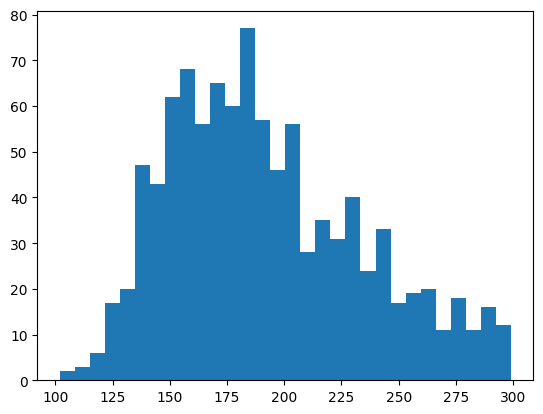

In [38]:
plt.hist([data[i].shape[0] for i in range(len(data))],
         bins=30);